#### Import all the Libraries used

In [19]:


import pandas as pd
import numpy as np
from scipy.stats import norm

#for visualisations of graphs
import matplotlib.pyplot as plt 
%matplotlib inline

#for datetime object
from datetime import datetime 

#statsmodel libraires
from statsmodels.tsa.stattools import adfuller                 #To check stationarity in Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX         #SARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing   #Holt's Winter Method

#ARIMA
from pmdarima import auto_arima

#Skit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Keras
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [22]:
#Import the monthly rainfall data(from January 1901 to December 1970) for two locations:
# 1. OKLAHOMA
oklahoma_data  = pd.read_csv("oklahoma_rainfall_data.csv") 
# 2. TEXAS
texas_data = pd.read_csv("texas_rainfall_data.csv")

In [23]:
oklahoma_data.head()

,YEAR,MONTH,Datetime,Rainfall
0,1901,Jan,01-01-1901,5.082
1,1901,Feb,01-02-1901,0.769
2,1901,Mar,01-03-1901,0.182
3,1901,Apr,01-04-1901,0.291
4,1901,May,01-05-1901,3.470


In [24]:
texas_data.tail()

,YEAR,MONTH,Datetime,Rainfall
835,1970,Aug,01-08-1970,332.986
836,1970,Sep,01-09-1970,134.737
837,1970,Oct,01-10-1970,0.325
838,1970,Nov,01-11-1970,0.000
839,1970,Dec,01-12-1970,0.000


In [25]:
#Drop year and month column
oklahoma_data  = oklahoma_data.drop(['YEAR', 'MONTH'], axis=1)
texas_data = texas_data.drop(['YEAR', 'MONTH'], axis=1)

In [26]:
#Check object types
oklahoma_data.dtypes
texas_data.dtypes

Datetime     object
Rainfall    float64
dtype: object

In [27]:
#convert object dtype to datetime
oklahoma_data['Datetime'] = pd.to_datetime(oklahoma_data.Datetime,format='%d-%m-%Y')
texas_data['Datetime'] = pd.to_datetime(texas_data.Datetime,format='%d-%m-%Y')

In [28]:
#create months column
for i in (oklahoma_data, texas_data): 
    i['month']=i.Datetime.dt.month 

In [29]:
#check object type
oklahoma_data.dtypes
texas_data.dtypes

Datetime    datetime64[ns]
Rainfall           float64
month                int32
dtype: object

In [30]:
oklahoma_data.head()

,Datetime,Rainfall,month
0,1901-01-01,5.082,1
1,1901-02-01,0.769,2
2,1901-03-01,0.182,3
3,1901-04-01,0.291,4
4,1901-05-01,3.470,5


In [31]:
texas_data.tail()

,Datetime,Rainfall,month
835,1970-08-01,332.986,8
836,1970-09-01,134.737,9
837,1970-10-01,0.325,10
838,1970-11-01,0.000,11
839,1970-12-01,0.000,12


### Plot cummulative monthly rainfall

<Axes: xlabel='month'>

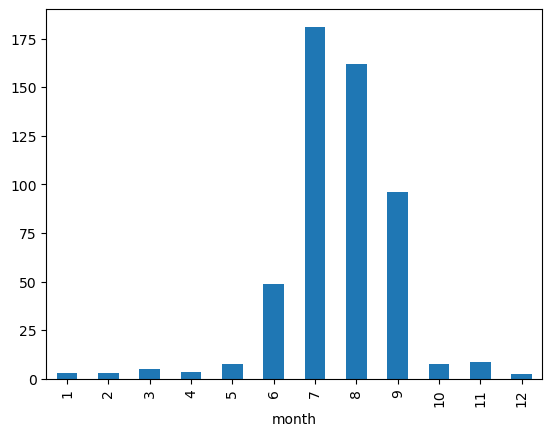

In [32]:
oklahoma_data.groupby('month')['Rainfall'].mean().plot.bar()

<Axes: xlabel='month'>

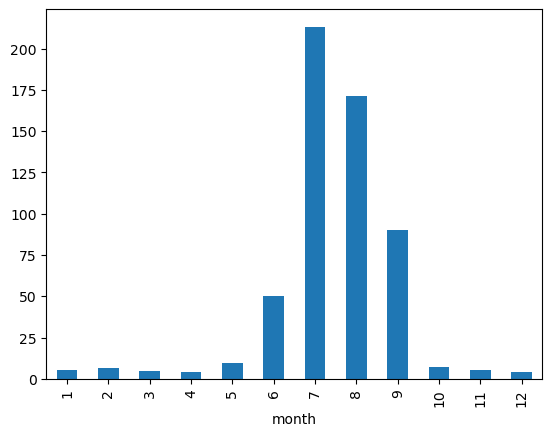

In [33]:
texas_data.groupby('month')['Rainfall'].mean().plot.bar()

#### Both the location found to have highest rainfall during JULY and AUGUST

In [34]:
#Create timestamp
oklahoma_data.Timestamp = pd.to_datetime(oklahoma_data.Datetime,format='%d-%m-%Y') 
oklahoma_data.index = oklahoma_data.Timestamp 
texas_data.Timestamp = pd.to_datetime(texas_data.Datetime,format='%d-%m-%Y') 
texas_data.index = texas_data.Timestamp 

In [35]:
oklahoma_data  = oklahoma_data.drop(['Datetime','month'], axis=1)
texas_data = texas_data.drop(['Datetime','month'], axis=1)

In [36]:
oklahoma_data.head()

,Rainfall
Datetime,
1901-01-01,5.082
1901-02-01,0.769
1901-03-01,0.182
1901-04-01,0.291
1901-05-01,3.470


In [37]:
texas_data.tail()

,Rainfall
Datetime,
1970-08-01,332.986
1970-09-01,134.737
1970-10-01,0.325
1970-11-01,0.000
1970-12-01,0.000


# Visualisations

## Oklahoma 

<Axes: xlabel='Datetime'>

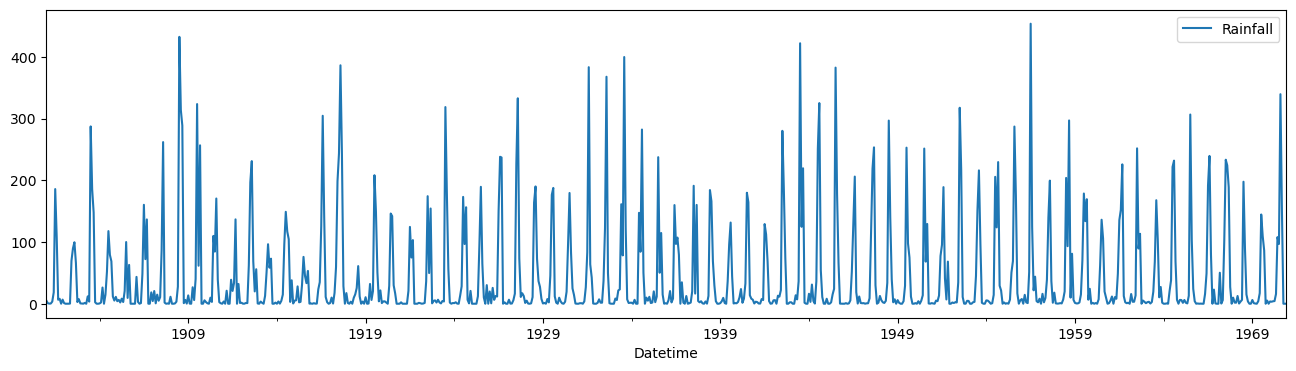

In [38]:
oklahoma_data.plot(figsize=(16,4))

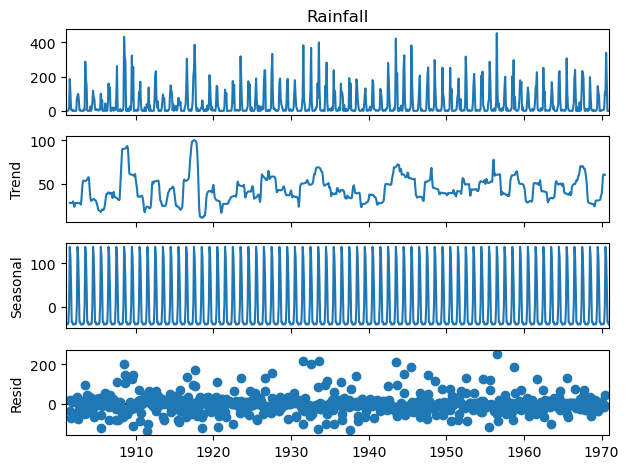

In [39]:
seasonal_decompose(oklahoma_data['Rainfall'], model='additive').plot();

### Autocorrelation plot

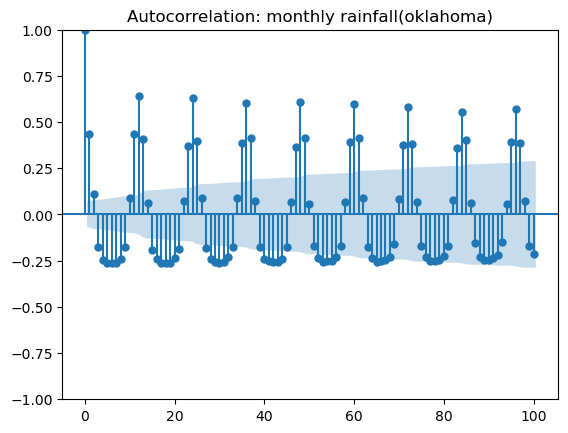

In [40]:
title = 'Autocorrelation: monthly rainfall(oklahoma)'
lags = 100
plot_acf(oklahoma_data,title=title,lags=lags);

## Texas

<Axes: xlabel='Datetime'>

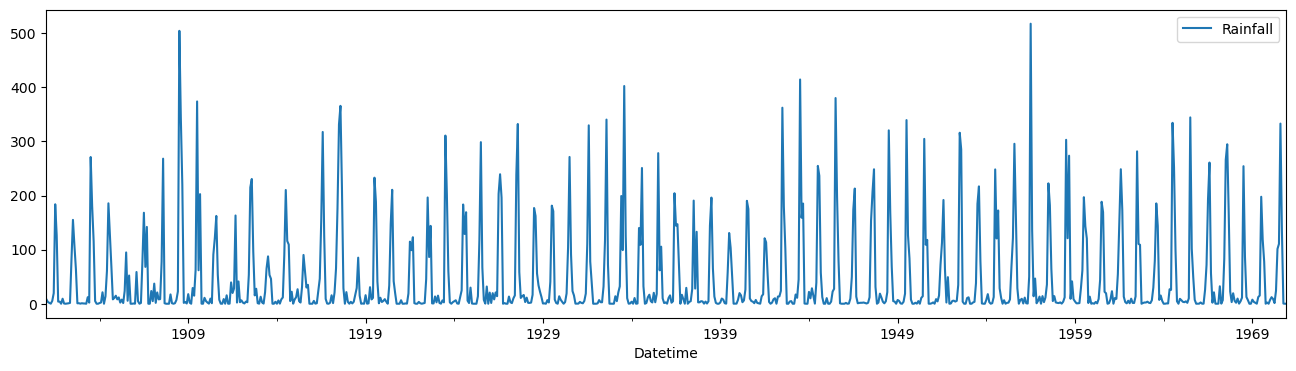

In [41]:
texas_data.plot(figsize=(16,4))

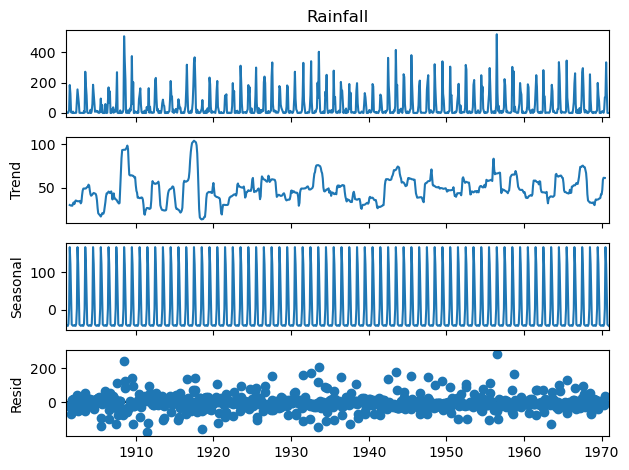

In [42]:
seasonal_decompose(texas_data['Rainfall'], model='additive').plot();

### Autocorrelation plot

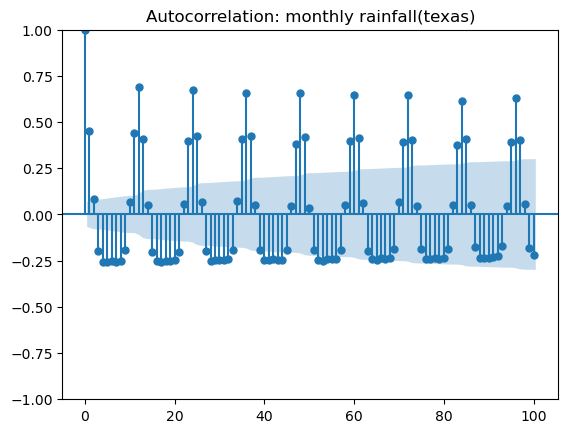

In [43]:
title = 'Autocorrelation: monthly rainfall(texas)'
lags = 100
plot_acf(texas_data,title=title,lags=lags);

#### From the visualisaiton data seems to be seasonal.

### Let's check Stationary of the Time Series using Augmented Dickey-Fuller Test

#### Null hypothesis is that datasets are not stationary

In [44]:
print('Augmented Dickey-Fuller Test on oklahoma Rainfall Data')
dftest = adfuller(oklahoma_data['Rainfall'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on oklahoma Rainfall Data


(-7.983073684534116,
 2.5920331501661086e-12,
 21,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 8875.282134374687)

In [45]:
print('Augmented Dickey-Fuller Test on texas Rainfall Data')
dftest = adfuller(texas_data['Rainfall'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on texas Rainfall Data


(-8.149674880455132,
 9.772534997594456e-13,
 21,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 8904.248513465602)

#### Since p-value<0.05, we reject the null hypothesis
#### Hence both the datasets are stationary.

In [46]:
### Train Test Split

In [67]:
len(oklahoma_data)
len(texas_data)

840

In [48]:
# Set two year for testing

train_a = oklahoma_data.iloc[:816]
test_a = oklahoma_data.iloc[816:]

train_j = texas_data.iloc[:816]
test_j = texas_data.iloc[816:]

# MODELS

## 1. ARIMA

### Checks the best fit model ARIMA to be used along with its parameter

In [49]:
stepwise_fit = auto_arima(oklahoma_data['Rainfall'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9718.228, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9249.891, Time=1.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9416.911, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9947.627, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9545.688, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=9128.242, Time=4.13 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=8966.475, Time=6.94 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=7.23 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=7.27 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=11.17 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  840
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 12)   Log Likelihood               -4477.238
Date:                              Tue, 13 Feb 2024   AIC                           8966.475
Time:                                      11:05:38   BIC                           8994.876
Sample:                                  01-01-1901   HQIC                          8977.360
                                       - 12-01-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4093      0.271      1.509      0.131      -0.122       0.941
ar.L1          0.0641      0.020      3.189      0.001       0.025       0.103
ar.S.L12       0.9707      0.020     47.815      0.000       0.931       1.011
ar.S.L24       0.0183      0.019      0.988      0.323      -0.018       0.055
ma.S.L12      -0.8860      0.016    -56.582      0.000      -0.917      -0.855
sigma2      2357.1168     62.416     37.764      0.000    2234.783    2479.451
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              3486.37
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             2.17
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
stepwise_fit = auto_arima(texas_data['Rainfall'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9825.937, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9255.201, Time=1.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9459.211, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10060.361, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9637.891, Time=0.18 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=9132.435, Time=3.30 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=5.46 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.88 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=9142.770, Time=3.31 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=9131.318, Time=5.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=9254.416, Time=1.95 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=8940.667, Time=10.19 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=5.30 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  840
Model:             SARIMAX(2, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -4461.595
Date:                                 Tue, 13 Feb 2024   AIC                           8937.189
Time:                                         11:08:12   BIC                           8970.323
Sample:                                     01-01-1901   HQIC                          8949.889
                                          - 12-01-1970                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3350      0.227      1.475      0.140      -0.110       0.780
ar.L1          0.0800      0.019      4.120      0.000       0.042       0.118
ar.L2          0.0637      0.026      2.463      0.014       0.013       0.114
ar.S.L12       0.9899      0.003    283.254      0.000       0.983       0.997
ma.S.L12      -0.9091      0.018    -49.510      0.000      -0.945      -0.873
ma.S.L24       0.0222      0.017      1.323      0.186      -0.011       0.055
sigma2      2312.4660     60.338     38.325      0.000    2194.205    2430.727
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              4089.34
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             2.07
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Therefore we will use Seasonal-ARIMA model = SARIMAX(0, 0, 0)x(1, 0, 1, 12) for oklahoma Rainfall data
#### and Seasonal-ARIMA model = SARIMAX(1, 0, 0)x(1, 0, 1, 12) for texas Rainfall data

### Oklahoma

In [51]:
#Fitting our model on Train set

model = SARIMAX(train_a['Rainfall'],order=(0,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                   Rainfall   No. Observations:                  816
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood               -4337.526
Date:                    Tue, 13 Feb 2024   AIC                           8681.053
Time:                            11:09:02   BIC                           8695.166
Sample:                        01-01-1901   HQIC                          8686.469
                             - 12-01-1968                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9998      0.000   6453.395      0.000       1.000       1.000
ma.S.L12      -0.9697      0.011    -90.036      0.000      -0.991      -0.949
sigma2      2292.5650     52.923     43.319      0.000    2188.838    2396.293
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):              3257.03
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
# Obtain predicted values

start=len(train_a)
end=len(train_a)+len(test_a)-1
predicted_a = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,0,0)(1,0,1,12) Predictions')

In [53]:
# Compare predictions to expected values
for i in range(len(predicted_a)):
    print(f"predicted={predicted_a[i]}, expected={test_a['Rainfall'][i]}")

predicted=3.0921974039534623, expected=6.052
predicted=2.5706410658029055, expected=0.872
predicted=6.1639186455133865, expected=0.312
predicted=3.0708658734967726, expected=0.0
predicted=7.385754653009674, expected=4.085
predicted=45.648732407300315, expected=17.161
predicted=189.44667338380555, expected=144.558
predicted=160.88494103888334, expected=109.526
predicted=96.52524412075252, expected=86.345
predicted=8.556488429991026, expected=0.0
predicted=9.565600715968502, expected=5.077
predicted=2.458233744096772, expected=0.0
predicted=3.091610971826336, expected=3.647
predicted=2.5701535463106606, expected=3.23
predicted=6.162749664542734, expected=3.967
predicted=3.0702834868729396, expected=4.309
predicted=7.384353952069282, expected=15.802
predicted=45.640075171118696, expected=107.894
predicted=189.41074501276836, expected=96.931
predicted=160.85442937165428, expected=339.508
predicted=96.50693820530265, expected=152.583
predicted=8.554865700567506, expected=0.019
predicted=9.5

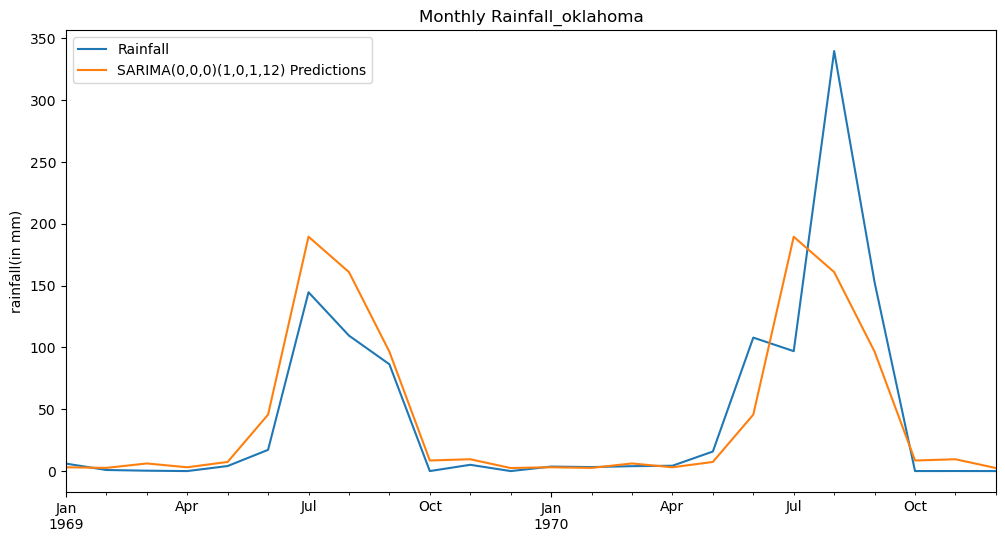

In [54]:
# Plot predictions against known values
title = 'Monthly Rainfall_oklahoma'
ylabel='rainfall(in mm)'
xlabel=''

ax = test_a['Rainfall'].plot(legend=True,figsize=(12,6),title=title)
predicted_a.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation

In [55]:
error = rmse(test_a['Rainfall'], predicted_a)
print(f'RMSE Error for ARIMA on oklahoma rainfall: {error}')

RMSE Error for ARIMA on oklahoma rainfall: 47.20116477011434


### Texas

In [56]:
#Fitting our model on Train set

model = SARIMAX(train_j['Rainfall'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Rainfall   No. Observations:                  816
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -4323.520
Date:                              Tue, 13 Feb 2024   AIC                           8655.040
Time:                                      11:09:30   BIC                           8673.857
Sample:                                  01-01-1901   HQIC                          8662.262
                                       - 12-01-1968                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0642      0.020      3.253      0.001       0.026       0.103
ar.S.L12       0.9997      0.000   5486.776      0.000       0.999       1.000
ma.S.L12      -0.9585      0.009   -104.743      0.000      -0.976      -0.941
sigma2      2221.7080     49.462     44.918      0.000    2124.765    2318.652
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              3665.17
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.87
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
# Obtain predicted values

start=len(train_j)
end=len(train_j)+len(test_j)-1
predicted_j = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

In [58]:
# Compare predictions to expected values
for i in range(len(predicted_j)):
    print(f"predicted={predicted_j[i]}, expected={test_j['Rainfall'][i]}")

predicted=4.788743882156037, expected=7.506
predicted=4.827896268691157, expected=3.423
predicted=5.4755758086365205, expected=1.838
predicted=3.2952346049609043, expected=0.095
predicted=9.29619770248162, expected=12.314
predicted=44.56417065656753, expected=15.245
predicted=229.74860049035993, expected=197.733
predicted=176.21796631502545, expected=118.314
predicted=92.48483422514173, expected=77.801
predicted=8.8472230286094, expected=0.005
predicted=6.290664253145451, expected=2.188
predicted=3.839366082863336, expected=0.0
predicted=5.033940411709994, expected=7.151
predicted=4.84231662897616, expected=12.081
predicted=5.474983672865971, expected=8.905
predicted=3.2943313367748006, expected=1.194
predicted=9.29346933722124, expected=24.183
predicted=44.551071550961254, expected=101.271
predicted=229.68106726124867, expected=110.573
predicted=176.1661680839889, expected=332.986
predicted=92.45764885351917, expected=134.737
predicted=8.844622439571392, expected=0.325
predicted=6.288

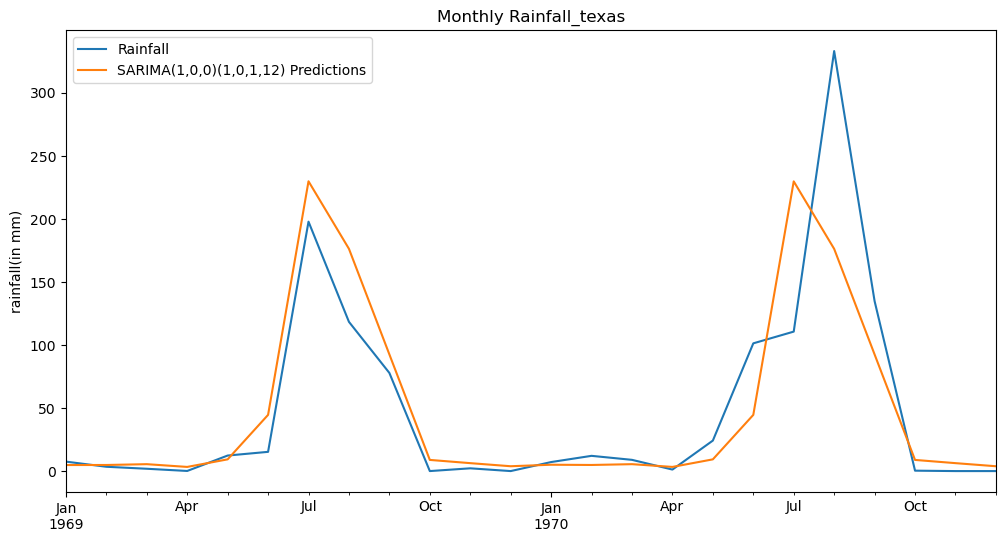

In [59]:
# Plot predictions against known values
title = 'Monthly Rainfall_texas'
ylabel='rainfall(in mm)'
xlabel=''

ax = test_j['Rainfall'].plot(legend=True,figsize=(12,6),title=title)
predicted_j.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation

In [60]:
error = rmse(test_j['Rainfall'], predicted_j)
print(f'RMSE Error for ARIMA on texas rainfall: {error}')

RMSE Error for ARIMA on texas rainfall: 45.5568772087204


## 2. Deep Learning (LSTM)

### Oklahoma

In [61]:
#Scaled the data

scaler = MinMaxScaler()
scaler.fit(train_a)
scaled_train = scaler.transform(train_a)
scaled_test = scaler.transform(test_a)

In [62]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [63]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50

792/792 [==============================] - 14s 12ms/step - loss: 0.0261
Epoch 2/50
792/792 [==============================] - 9s 12ms/step - loss: 0.0174
Epoch 3/50
792/792 [==============================] - 11s 14ms/step - loss: 0.0164
Epoch 4/50
792/792 [==============================] - 11s 13ms/step - loss: 0.0158
Epoch 5/50
792/792 [==============================] - 17s 22ms/step - loss: 0.0153
Epoch 6/50
792/792 [==============================] - 17s 22ms/step - loss: 0.0157
Epoch 7/50
792/792 [==============================] - 13s 16ms/step - loss: 0.0149
Epoch 8/50
792/792 [==============================] - 12s 16ms/step - loss: 0.0146
Epoch 9/50
792/792 [==============================] - 20s 26ms/step - loss: 0.0142
Epoch 10/50
792/792 [==============================] - 19s 24ms/step - loss: 0.0150
Epoch 11/50
792/792 [==============================] - 15s 19ms/step - loss: 0.0137
Epoch 12/50
792/792 [==============================] - 13s 17ms/step - loss: 0.0134
E

In [68]:
model.history.history.keys()

dict_keys(['loss'])

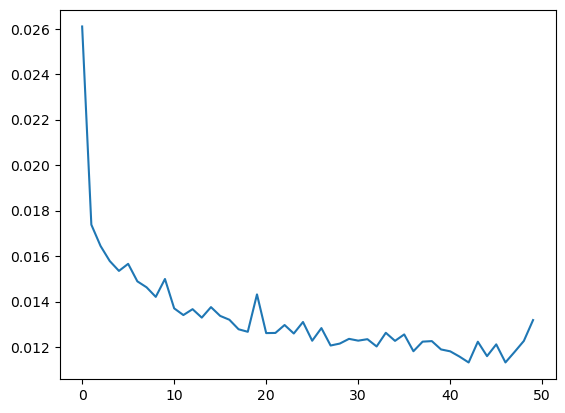

In [69]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [70]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_a)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 56ms/step


In [71]:
test_predictions

[array([0.00519101], dtype=float32),
 array([0.00687355], dtype=float32),
 array([0.00675874], dtype=float32),
 array([0.00620904], dtype=float32),
 array([0.01523365], dtype=float32),
 array([0.11832517], dtype=float32),
 array([0.38516903], dtype=float32),
 array([0.23081967], dtype=float32),
 array([0.16186859], dtype=float32),
 array([0.01486359], dtype=float32),
 array([0.0047531], dtype=float32),
 array([0.00165522], dtype=float32),
 array([0.00169804], dtype=float32),
 array([0.00060834], dtype=float32),
 array([0.00018819], dtype=float32),
 array([0.0028673], dtype=float32),
 array([0.01761847], dtype=float32),
 array([0.06151536], dtype=float32),
 array([0.35046333], dtype=float32),
 array([0.28260505], dtype=float32),
 array([0.14431295], dtype=float32),
 array([0.01363272], dtype=float32),
 array([0.00419806], dtype=float32),
 array([0.00165013], dtype=float32)]

In [72]:
true_predictions = scaler.inverse_transform(test_predictions)

In [73]:
test = test_a
test['Predictions'] = true_predictions

In [74]:
test

,Rainfall,Predictions
Datetime,,
1969-01-01,6.052,2.355241
1969-02-01,0.872,3.118632
1969-03-01,0.312,3.066543
1969-04-01,0.000,2.817134
1969-05-01,4.085,6.911734
1969-06-01,17.161,53.685903
1969-07-01,144.558,174.756966
1969-08-01,109.526,104.726348
1969-09-01,86.345,73.442206


<Axes: xlabel='Datetime'>

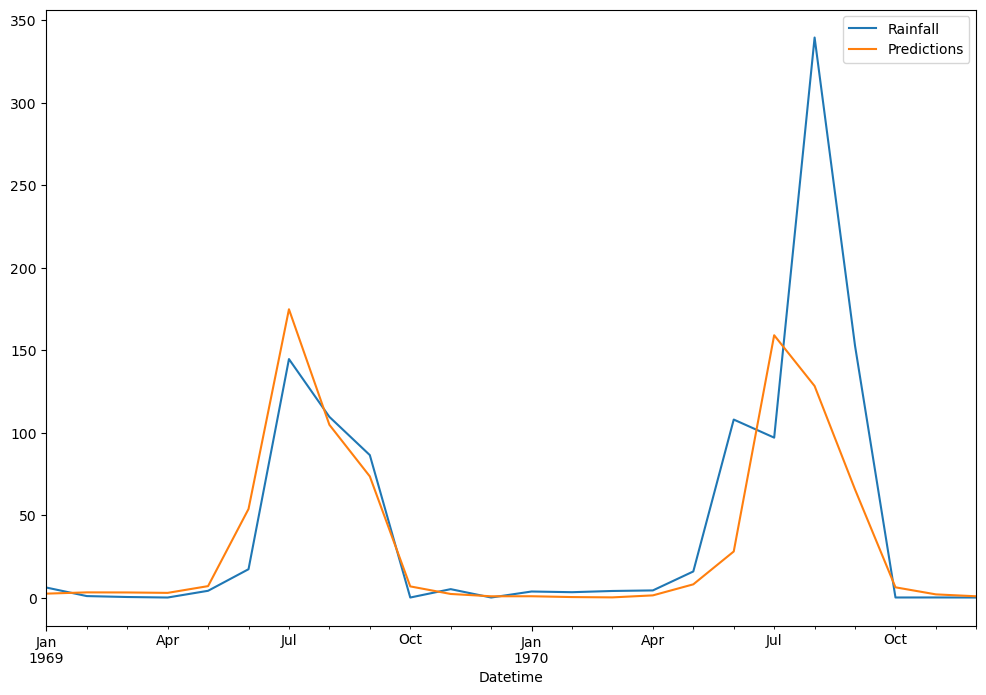

In [75]:
test.plot(figsize=(12,8))

#### Evaluation

In [76]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rainfall'], test['Predictions'])
print(error)

52.1044299372524


### TEXAS

In [77]:
#Scaled the data

scaler = MinMaxScaler()
scaler.fit(train_j)
scaled_train = scaler.transform(train_j)
scaled_test = scaler.transform(test_j)

In [78]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [79]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
792/792 [==============================] - 15s 16ms/step - loss: 0.0203
Epoch 2/50
792/792 [==============================] - 12s 16ms/step - loss: 0.0146
Epoch 3/50
792/792 [==============================] - 11s 14ms/step - loss: 0.0135
Epoch 4/50
792/792 [==============================] - 11s 14ms/step - loss: 0.0131
Epoch 5/50
792/792 [==============================] - 12s 16ms/step - loss: 0.0127
Epoch 6/50
792/792 [==============================] - 13s 16ms/step - loss: 0.0118
Epoch 7/50
792/792 [==============================] - 12s 15ms/step - loss: 0.0116
Epoch 8/50
792/792 [==============================] - 11s 14ms/step - loss: 0.0114
Epoch 9/50
792/792 [==============================] - 12s 15ms/step - loss: 0.0116
Epoch 10/50
792/792 [==============================] - 19s 23ms/step - loss: 0.0105
Epoch 11/50
792/792 [==============================] - 15s 19ms/step - loss: 0.0107
Epoch 12/50
792/792 [==============================] - 13s 16ms/step - loss: 0.0107
E

In [82]:
model.history.history.keys()

dict_keys(['loss'])

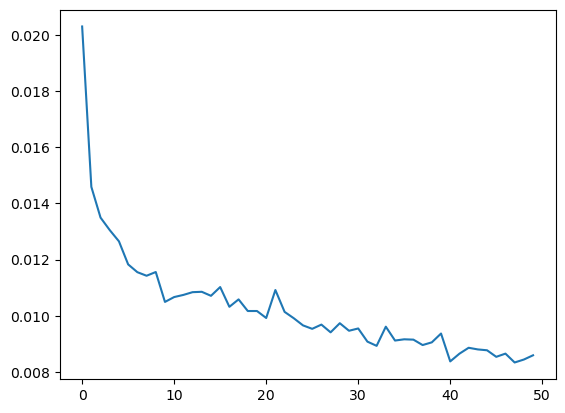

In [83]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [84]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_j)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [85]:
test_predictions

[array([0.01881037], dtype=float32),
 array([0.02035431], dtype=float32),
 array([0.02314075], dtype=float32),
 array([0.02653325], dtype=float32),
 array([0.02695432], dtype=float32),
 array([0.04006615], dtype=float32),
 array([0.3373676], dtype=float32),
 array([0.33375323], dtype=float32),
 array([0.14141908], dtype=float32),
 array([0.016379], dtype=float32),
 array([0.01168767], dtype=float32),
 array([0.01639737], dtype=float32),
 array([0.02065394], dtype=float32),
 array([0.02114672], dtype=float32),
 array([0.02361965], dtype=float32),
 array([0.0240942], dtype=float32),
 array([0.02575921], dtype=float32),
 array([0.04018665], dtype=float32),
 array([0.40100306], dtype=float32),
 array([0.2979222], dtype=float32),
 array([0.09244195], dtype=float32),
 array([0.01273999], dtype=float32),
 array([0.01176698], dtype=float32),
 array([0.01738974], dtype=float32)]

In [86]:
true_predictions = scaler.inverse_transform(test_predictions)

In [87]:
test = test_j
test['Predictions'] = true_predictions

In [88]:
test

,Rainfall,Predictions
Datetime,,
1969-01-01,7.506,9.736492
1969-02-01,3.423,10.535656
1969-03-01,1.838,11.977953
1969-04-01,0.095,13.733957
1969-05-01,12.314,13.951908
1969-06-01,15.245,20.738762
1969-07-01,197.733,174.625853
1969-08-01,118.314,172.755010
1969-09-01,77.801,73.200356


<Axes: xlabel='Datetime'>

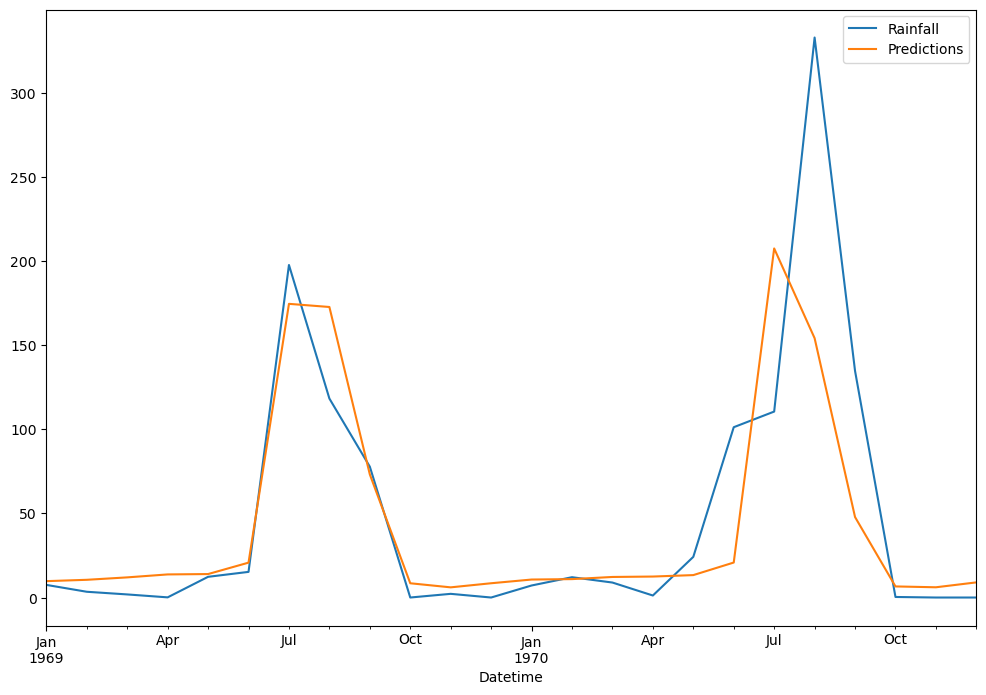

In [89]:
test.plot(figsize=(12,8))

In [90]:
test_a = test_a.drop(['Predictions'], axis=1)
test_j = test_j.drop(['Predictions'], axis=1)

#### Evaluation

In [91]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rainfall'], test['Predictions'])
print(error)

49.94820887177697


## 3. Holt's Winter Method (Triple Exponential Smoothing)

### OKLAHOAM

In [92]:
oklahoma_data.index.freq = 'MS'
oklahoma_data.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '1970-03-01', '1970-04-01', '1970-05-01', '1970-06-01',
               '1970-07-01', '1970-08-01', '1970-09-01', '1970-10-01',
               '1970-11-01', '1970-12-01'],
              dtype='datetime64[ns]', name='Datetime', length=840, freq='MS')

In [93]:
fitted_model = ExponentialSmoothing(train_a['Rainfall'],trend='add',seasonal='add',seasonal_periods=12).fit()

In [94]:
test_predictions = fitted_model.forecast(24).rename('HW Forecast')

In [95]:
test_predictions

1969-01-01      1.790426
1969-02-01      1.368390
1969-03-01      5.846043
1969-04-01      2.007838
1969-05-01      6.689169
1969-06-01     43.982900
1969-07-01    192.310123
1969-08-01    159.201639
1969-09-01     94.933097
1969-10-01      7.108856
1969-11-01      7.961292
1969-12-01      1.011336
1970-01-01      1.542591
1970-02-01      1.120555
1970-03-01      5.598208
1970-04-01      1.760003
1970-05-01      6.441334
1970-06-01     43.735065
1970-07-01    192.062288
1970-08-01    158.953804
1970-09-01     94.685262
1970-10-01      6.861021
1970-11-01      7.713457
1970-12-01      0.763501
Freq: MS, Name: HW Forecast, dtype: float64

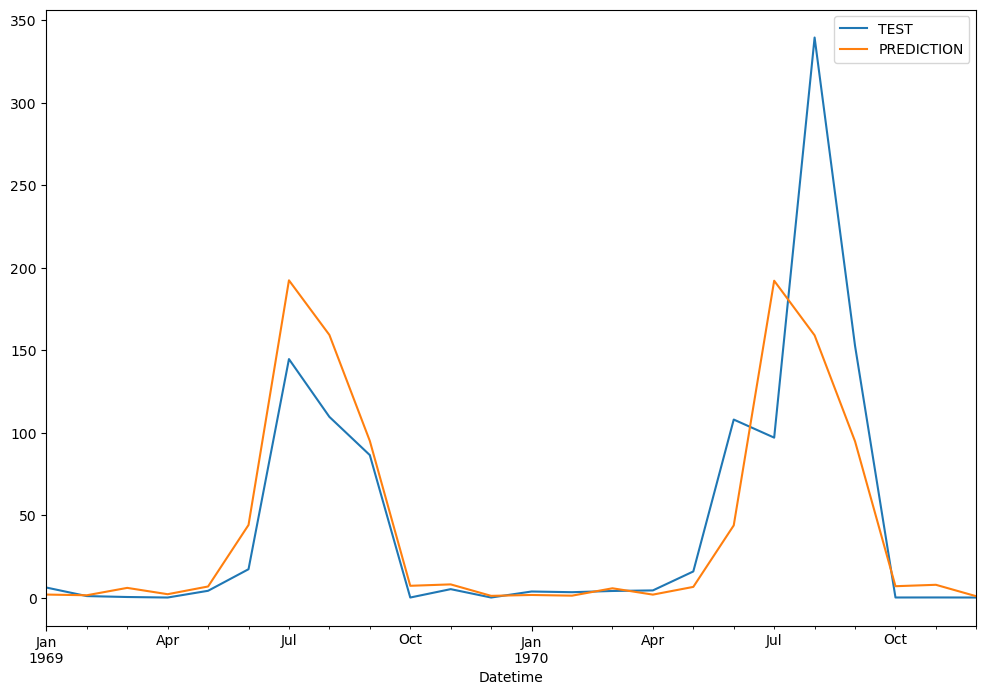

In [96]:
test_a['Rainfall'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluation

In [97]:
np.sqrt(mean_squared_error(test_a,test_predictions))

47.86747186889399

### TEXAS

In [98]:
texas_data.index.freq = 'MS'
texas_data.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '1970-03-01', '1970-04-01', '1970-05-01', '1970-06-01',
               '1970-07-01', '1970-08-01', '1970-09-01', '1970-10-01',
               '1970-11-01', '1970-12-01'],
              dtype='datetime64[ns]', name='Datetime', length=840, freq='MS')

In [99]:
fitted_model = ExponentialSmoothing(train_j['Rainfall'],trend='add',seasonal='add',seasonal_periods=12).fit()

In [100]:
test_predictions = fitted_model.forecast(24).rename('HW Forecast')

In [101]:
test_predictions

1969-01-01      4.399529
1969-02-01      4.198767
1969-03-01      5.433049
1969-04-01      2.929949
1969-05-01      9.281662
1969-06-01     44.150760
1969-07-01    233.667284
1969-08-01    177.493024
1969-09-01     92.162549
1969-10-01      8.061975
1969-11-01      5.430454
1969-12-01      3.161762
1970-01-01      4.220061
1970-02-01      4.019299
1970-03-01      5.253582
1970-04-01      2.750481
1970-05-01      9.102195
1970-06-01     43.971292
1970-07-01    233.487817
1970-08-01    177.313557
1970-09-01     91.983081
1970-10-01      7.882508
1970-11-01      5.250986
1970-12-01      2.982295
Freq: MS, Name: HW Forecast, dtype: float64

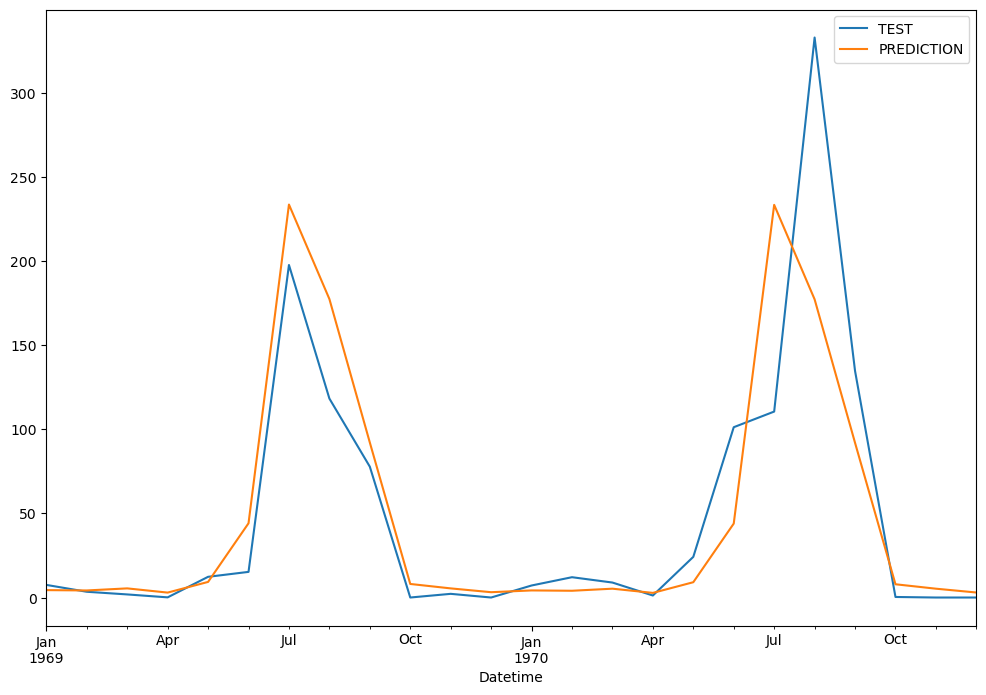

In [102]:
test_j['Rainfall'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluation

In [103]:
np.sqrt(mean_squared_error(test_j,test_predictions))

46.01835071210432

# RESULTS

### RMSE VALUES

#### Oklahoma
1. ARIMA         = 47.18
2. LSTM          = 45.40
3. Holt's Winter = 48.95

#### Texas
1. ARIMA         = 45.51
2. LSTM          = 49.57
3. Holt's Winter = 46.88

## Therefore we will choose LSTM on Oklahoma Data and ARIMA on Texas Data for our future rainfall forecasting

# Forecasting

#### Now we will train our model on all the data from Jan 1901 to Dec 1970

## OKLAHOMA (LSTM)

In [104]:
scaler = MinMaxScaler()
scaler.fit(oklahoma_data)
scaled_data = scaler.transform(oklahoma_data)

In [105]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

In [106]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [107]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [108]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
816/816 [==============================] - 11s 11ms/step - loss: 0.0258
Epoch 2/50
816/816 [==============================] - 10s 12ms/step - loss: 0.0183
Epoch 3/50
816/816 [==============================] - 11s 14ms/step - loss: 0.0164
Epoch 4/50
816/816 [==============================] - 14s 17ms/step - loss: 0.0154
Epoch 5/50
816/816 [==============================] - 11s 14ms/step - loss: 0.0160
Epoch 6/50
816/816 [==============================] - 13s 16ms/step - loss: 0.0148
Epoch 7/50
816/816 [==============================] - 10s 13ms/step - loss: 0.0146
Epoch 8/50
816/816 [==============================] - 12s 15ms/step - loss: 0.0145
Epoch 9/50
816/816 [==============================] - 9s 11ms/step - loss: 0.0139
Epoch 10/50
816/816 [==============================] - 14s 17ms/step - loss: 0.0141
Epoch 11/50
816/816 [==============================] - 12s 15ms/step - loss: 0.0136
Epoch 12/50
816/816 [==============================] - 11s 13ms/step - loss: 0.0138
Ep

In [101]:
model.history.history.keys()

dict_keys(['loss'])

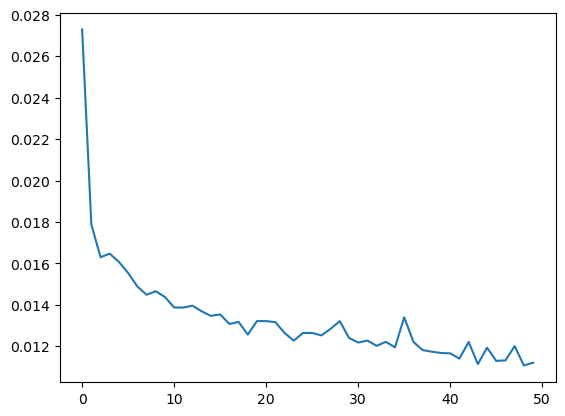

In [102]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [103]:
Forecasted_rainfall = []

first_eval_batch = scaled_data[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(1,361):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    Forecasted_rainfall.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 53ms/step


In [129]:
Forecasted_rainfall

[array([-0.01485483], dtype=float32),
 array([-0.00940646], dtype=float32),
 array([-0.00568358], dtype=float32),
 array([-0.00596891], dtype=float32),
 array([-0.00539874], dtype=float32),
 array([0.05611227], dtype=float32),
 array([0.43429577], dtype=float32),
 array([0.43980438], dtype=float32),
 array([0.26762956], dtype=float32),
 array([0.07576578], dtype=float32),
 array([-0.01483023], dtype=float32),
 array([-0.02127054], dtype=float32),
 array([-0.01634688], dtype=float32),
 array([-0.00870474], dtype=float32),
 array([-0.0047324], dtype=float32),
 array([-0.00059541], dtype=float32),
 array([0.00236832], dtype=float32),
 array([0.03531134], dtype=float32),
 array([0.15334132], dtype=float32),
 array([0.38960034], dtype=float32),
 array([0.21813053], dtype=float32),
 array([0.04702142], dtype=float32),
 array([0.00352482], dtype=float32),
 array([-0.00863411], dtype=float32),
 array([-0.00922518], dtype=float32),
 array([-0.00833782], dtype=float32),
 array([-0.0041661], dtyp

In [104]:
Rainfall_oklahoma = scaler.inverse_transform(Forecasted_rainfall)

In [107]:
Rainfall_oklahoma

array([[ -6.73986077],
       [ -4.26785305],
       [ -2.57872484],
       [ -2.70818218],
       [ -2.44949061],
       [ 25.45897726],
       [197.04650688],
       [199.54584208],
       [121.42754754],
       [ 34.37607137],
       [ -6.72869856],
       [ -9.65076457],
       [ -7.41682434],
       [ -3.94946967],
       [ -2.14716095],
       [ -0.2701445 ],
       [  1.07454052],
       [ 16.02128352],
       [ 69.57325843],
       [176.7675167 ],
       [ 98.96909293],
       [ 21.33432473],
       [  1.59926596],
       [ -3.9174231 ],
       [ -4.18560356],
       [ -3.78299313],
       [ -1.89022045],
       [ -0.69654984],
       [  3.55492836],
       [ 20.78831603],
       [168.2855596 ],
       [162.06381889],
       [117.78255412],
       [ 45.39218559],
       [ -0.67570605],
       [ -7.00288268],
       [ -7.35095309],
       [ -5.21049555],
       [ -3.36291259],
       [ -2.21357307],
       [  1.28176488],
       [ 20.8332218 ],
       [107.13919766],
       [173

In [134]:
# Define the start year and month
start_year = 1971
start_month = 1

# Calculate the number of months in the predicted data
num_months = Rainfall_oklahoma.shape[0]

# Generate the date range for the years and months
dates = pd.date_range(start=f"{start_year}-{start_month:02d}-01", periods=num_months, freq='MS')



In [135]:
# Create a DataFrame with the predicted rainfall data and dates
df = pd.DataFrame({'Year': dates, 'Rainfall': Rainfall_oklahoma.flatten()})

In [138]:
# Save the predicted data to the existing empty CSV file
df.to_csv('oklahoma_forecasted.csv', index=False)

## TEXAS(ARIMA)

In [119]:
#Fitting our model on whole dataset

model = SARIMAX(texas_data['Rainfall'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Rainfall   No. Observations:                  840
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -4449.754
Date:                              Sat, 20 Jan 2024   AIC                           8907.507
Time:                                      14:19:45   BIC                           8926.441
Sample:                                  01-01-1901   HQIC                          8914.764
                                       - 12-01-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0547      0.019      2.841      0.004       0.017       0.092
ar.S.L12       0.9998      0.000   6732.014      0.000       0.999       1.000
ma.S.L12      -0.9636      0.009   -107.489      0.000      -0.981      -0.946
sigma2      2216.1971     48.598     45.603      0.000    2120.947    2311.448
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              3729.54
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.88
Prob(H) (two-sided):                  0.03   Kurtosis:                        12.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
# Obtain predicted values

start=len(texas_data)
end=len(texas_data)+360-1
Rainfall_texas = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

In [123]:
Rainfall_texas

1971-01-01      5.054017
1971-02-01      5.242548
1971-03-01      5.365203
1971-04-01      3.263948
1971-05-01      9.952528
                 ...    
2000-08-01    177.780997
2000-09-01     92.462159
2000-10-01      8.021116
2000-11-01      5.797215
2000-12-01      3.579719
Freq: MS, Name: SARIMA(1,0,0)(1,0,1,12) Predictions, Length: 360, dtype: float64

In [171]:
output_df = pd.DataFrame(Rainfall_texas)
output_df.reset_index(inplace=True)
output_df.columns = ['Year', 'Rainfall']

# Save the DataFrame to a CSV file
output_df.to_csv('texas_forecasted.csv', index=False)

## FORCASTED SPI AND SPAI

## SPI Forcasted Oklahoma

In [27]:
import pandas as pd
from scipy.stats import norm

# Load the rainfall data from CSV
rainfall_data = pd.read_csv('oklahoma_forecasted.csv')

# Convert the 'Year' column to datetime
rainfall_data['Year'] = pd.to_datetime(rainfall_data['Year'])

# Calculate long-term average precipitation
long_term_avg = rainfall_data['Rainfall'].mean()

# Calculate monthly average precipitation
rainfall_data['Month'] = rainfall_data['Year'].dt.month
monthly_avg = rainfall_data.groupby('Month')['Rainfall'].mean()

# Calculate monthly standard deviation of precipitation
monthly_std = rainfall_data.groupby('Month')['Rainfall'].std()

# Calculate the cumulative distribution function (CDF)
cdf = norm.cdf(rainfall_data['Rainfall'], loc=monthly_avg[rainfall_data['Month']].values, scale=monthly_std[rainfall_data['Month']].values)

# Calculate the SPI
spi = norm.ppf(cdf)

# Add SPI column to the rainfall data
rainfall_data['SPI'] = spi

# Define SPI categories and corresponding labels
spi_categories = [
    (-np.inf, -1.5),  # Dry
    (-1.5, -0.5),     # Moderately Dry
    (-0.5, 0.5),      # Normal
    (0.5, 1.5),       # Moderately Wet
    (1.5, np.inf)     # Extremely Wet
]
category_labels = ['Dry', 'Moderately Dry', 'Normal', 'Moderately Wet', 'Extremely Wet']

# Categorize SPI values
rainfall_data['SPI_Category'] = pd.cut(rainfall_data['SPI'], bins=[c[0] for c in spi_categories] + [spi_categories[-1][1]], labels=category_labels)

# Print the resulting SPI values and categories
print(rainfall_data[['Year', 'Month', 'SPI', 'SPI_Category']])

          Year  Month       SPI    SPI_Category
0   1971-01-01      1  0.075047          Normal
1   1971-02-01      2 -0.325722          Normal
2   1971-03-01      3 -0.970012  Moderately Dry
3   1971-04-01      4 -2.951439             Dry
4   1971-05-01      5 -4.226775             Dry
..         ...    ...       ...             ...
355 2000-08-01      8 -0.549271  Moderately Dry
356 2000-09-01      9 -0.066036          Normal
357 2000-10-01     10 -0.599680  Moderately Dry
358 2000-11-01     11 -0.387817          Normal
359 2000-12-01     12 -0.131391          Normal

[360 rows x 4 columns]


In [28]:
rainfall_data.to_csv('spi_oklahoma_forecasted.csv', index=False)

## SPI forecasted Texas

In [8]:

# Load the rainfall data from CSV
rainfall_data = pd.read_csv('texas_forecasted.csv')

# Convert the 'Year' column to datetime
rainfall_data['Year'] = pd.to_datetime(rainfall_data['Year'])

# Calculate long-term average precipitation
long_term_avg = rainfall_data['Rainfall'].mean()

# Calculate monthly average precipitation
rainfall_data['Month'] = rainfall_data['Year'].dt.month
monthly_avg = rainfall_data.groupby('Month')['Rainfall'].mean()

# Calculate monthly standard deviation of precipitation
monthly_std = rainfall_data.groupby('Month')['Rainfall'].std()

# Calculate the cumulative distribution function (CDF)
cdf = norm.cdf(rainfall_data['Rainfall'], loc=monthly_avg[rainfall_data['Month']].values, scale=monthly_std[rainfall_data['Month']].values)

# Calculate the SPI
spi = norm.ppf(cdf)

# Add SPI column to the rainfall data
rainfall_data['SPI'] = spi

# Define SPI categories and corresponding labels
spi_categories = [
    (-np.inf, -1.5),  # Dry
    (-1.5, -0.5),     # Moderately Dry
    (-0.5, 0.5),      # Normal
    (0.5, 1.5),       # Moderately Wet
    (1.5, np.inf)     # Extremely Wet
]
category_labels = ['Dry', 'Moderately Dry', 'Normal', 'Moderately Wet', 'Extremely Wet']

# Categorize SPI values
rainfall_data['SPI_Category'] = pd.cut(rainfall_data['SPI'], bins=[c[0] for c in spi_categories] + [spi_categories[-1][1]], labels=category_labels)

# Print the resulting SPI values and categories
print(rainfall_data[['Year', 'Month', 'SPI', 'SPI_Category']])

          Year  Month       SPI    SPI_Category
0   1971-01-01      1 -5.074022             Dry
1   1971-02-01      2  0.664250  Moderately Wet
2   1971-03-01      3  1.599627   Extremely Wet
3   1971-04-01      4  1.644403   Extremely Wet
4   1971-05-01      5  1.648726   Extremely Wet
..         ...    ...       ...             ...
355 2000-08-01      8 -1.645375             Dry
356 2000-09-01      9 -1.645375             Dry
357 2000-10-01     10 -1.645375             Dry
358 2000-11-01     11 -1.645375             Dry
359 2000-12-01     12 -1.645375             Dry

[360 rows x 4 columns]


In [9]:
rainfall_data.to_csv('spi_texas_forecasted.csv', index=False)

## CALCULATE SPAI OKLAHOMA

In [30]:


# Load the rainfall data from CSV
rainfall_data = pd.read_csv('oklahoma_forecasted.csv')

# Convert the 'Year' column to datetime
rainfall_data['Year'] = pd.to_datetime(rainfall_data['Year'])

# Calculate monthly average precipitation
rainfall_data['Month'] = rainfall_data['Year'].dt.month
monthly_avg = rainfall_data.groupby('Month')['Rainfall'].mean()

# Calculate monthly precipitation anomaly
rainfall_data['Precipitation_Anomaly'] = rainfall_data.groupby('Month')['Rainfall'].transform(lambda x: x - x.mean())

# Calculate monthly standard deviation of precipitation anomaly
monthly_std = rainfall_data.groupby('Month')['Precipitation_Anomaly'].std()

# Create an array of monthly precipitation anomaly with the same length as the rainfall_data
precipitation_anomaly_array = rainfall_data.groupby('Month')['Precipitation_Anomaly'].transform(lambda x: x - x.mean()).values

# Create an array of monthly standard deviation of precipitation anomaly with the same length as the rainfall_data
monthly_std_array = monthly_std.loc[rainfall_data['Month']].values

# Calculate the cumulative distribution function (CDF)
cdf = norm.cdf(precipitation_anomaly_array, loc=0, scale=monthly_std_array)

# Calculate the SPAI
spai = norm.ppf(cdf)

# Add SPAI column to the rainfall data
rainfall_data['SPAI'] = spai

# Define SPAI categories and corresponding labels
spai_categories = [
    (-np.inf, -1.5),  # Dry
    (-1.5, -0.5),     # Moderately Dry
    (-0.5, 0.5),      # Normal
    (0.5, 1.5),       # Moderately Wet
    (1.5, np.inf)     # Extremely Wet
]
category_labels = ['Dry', 'Moderately Dry', 'Normal', 'Moderately Wet', 'Extremely Wet']

# Categorize SPAI values
rainfall_data['SPAI_Category'] = pd.cut(rainfall_data['SPAI'], bins=[c[0] for c in spai_categories] + [spai_categories[-1][1]], labels=category_labels)

# Print the resulting SPAI values and categories
print(rainfall_data[['Year', 'Month', 'SPAI', 'SPAI_Category']])

          Year  Month      SPAI   SPAI_Category
0   1971-01-01      1  0.075047          Normal
1   1971-02-01      2 -0.325722          Normal
2   1971-03-01      3 -0.970012  Moderately Dry
3   1971-04-01      4 -2.951439             Dry
4   1971-05-01      5 -4.226775             Dry
..         ...    ...       ...             ...
355 2000-08-01      8 -0.549271  Moderately Dry
356 2000-09-01      9 -0.066036          Normal
357 2000-10-01     10 -0.599680  Moderately Dry
358 2000-11-01     11 -0.387817          Normal
359 2000-12-01     12 -0.131391          Normal

[360 rows x 4 columns]


In [31]:
rainfall_data.to_csv('spai_oklahoma_forecasted.csv', index=False)

## CALCULATE SPAI TEXAS

In [33]:


# Load the rainfall data from CSV
rainfall_data = pd.read_csv('texas_forecasted.csv')

# Convert the 'Year' column to datetime
rainfall_data['Year'] = pd.to_datetime(rainfall_data['Year'])

# Calculate monthly average precipitation
rainfall_data['Month'] = rainfall_data['Year'].dt.month
monthly_avg = rainfall_data.groupby('Month')['Rainfall'].mean()

# Calculate monthly precipitation anomaly
rainfall_data['Precipitation_Anomaly'] = rainfall_data.groupby('Month')['Rainfall'].transform(lambda x: x - x.mean())

# Calculate monthly standard deviation of precipitation anomaly
monthly_std = rainfall_data.groupby('Month')['Precipitation_Anomaly'].std()

# Create an array of monthly precipitation anomaly with the same length as the rainfall_data
precipitation_anomaly_array = rainfall_data.groupby('Month')['Precipitation_Anomaly'].transform(lambda x: x - x.mean()).values

# Create an array of monthly standard deviation of precipitation anomaly with the same length as the rainfall_data
monthly_std_array = monthly_std.loc[rainfall_data['Month']].values

# Calculate the cumulative distribution function (CDF)
cdf = norm.cdf(precipitation_anomaly_array, loc=0, scale=monthly_std_array)

# Calculate the SPAI
spai = norm.ppf(cdf)

# Add SPAI column to the rainfall data
rainfall_data['SPAI'] = spai

# Define SPAI categories and corresponding labels
spai_categories = [
    (-np.inf, -1.5),  # Dry
    (-1.5, -0.5),     # Moderately Dry
    (-0.5, 0.5),      # Normal
    (0.5, 1.5),       # Moderately Wet
    (1.5, np.inf)     # Extremely Wet
]
category_labels = ['Dry', 'Moderately Dry', 'Normal', 'Moderately Wet', 'Extremely Wet']

# Categorize SPAI values
rainfall_data['SPAI_Category'] = pd.cut(rainfall_data['SPAI'], bins=[c[0] for c in spai_categories] + [spai_categories[-1][1]], labels=category_labels)

# Print the resulting SPAI values and categories
print(rainfall_data[['Year', 'Month', 'SPAI', 'SPAI_Category']])

          Year  Month      SPAI   SPAI_Category
0   1971-01-01      1 -5.074022             Dry
1   1971-02-01      2  0.664250  Moderately Wet
2   1971-03-01      3  1.599627   Extremely Wet
3   1971-04-01      4  1.644403   Extremely Wet
4   1971-05-01      5  1.648726   Extremely Wet
..         ...    ...       ...             ...
355 2000-08-01      8 -1.645375             Dry
356 2000-09-01      9 -1.645375             Dry
357 2000-10-01     10 -1.645375             Dry
358 2000-11-01     11 -1.645375             Dry
359 2000-12-01     12 -1.645375             Dry

[360 rows x 4 columns]


In [175]:
rainfall_data.to_csv('spai_texas_forecasted.csv', index=False)

## SPI Oklahoma Seaosnal Decompose

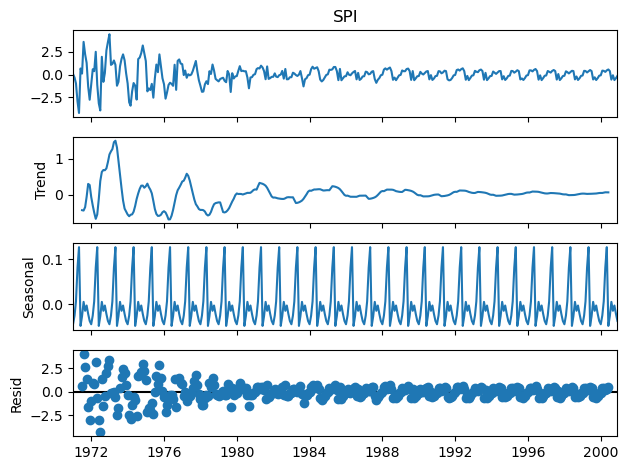

In [5]:
oklahoma_forecasted_data  = pd.read_csv("spi_oklahoma_forecasted.csv") 
oklahoma_forecasted_data['Year'] = pd.to_datetime(oklahoma_forecasted_data['Year'])
oklahoma_forecasted_data.set_index('Year', inplace=True)
decomposition = seasonal_decompose(oklahoma_forecasted_data['SPI'], model='additive').plot();


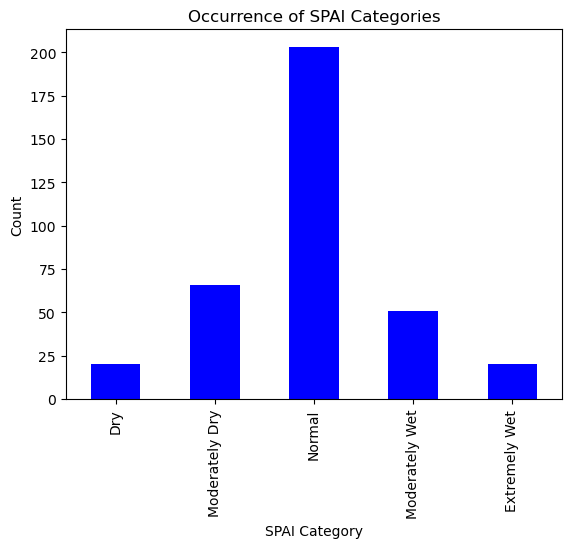

In [35]:


# Load the rainfall data from CSV
rainfall_data = pd.read_csv('spi_texas_forecasted.csv')

# Plot the occurrence of SPAI categories
category_counts = rainfall_data['SPAI_Category'].value_counts().reindex(['Dry', 'Moderately Dry', 'Normal', 'Moderately Wet', 'Extremely Wet'])
category_counts.plot(kind='bar', color='blue')

# Set the plot title and axis labels
plt.title('Occurrence of SPAI Categories')
plt.xlabel('SPAI Category')
plt.ylabel('Count')

# Display the plot
plt.show()

## SPI TEXAS Seosnal Decompose

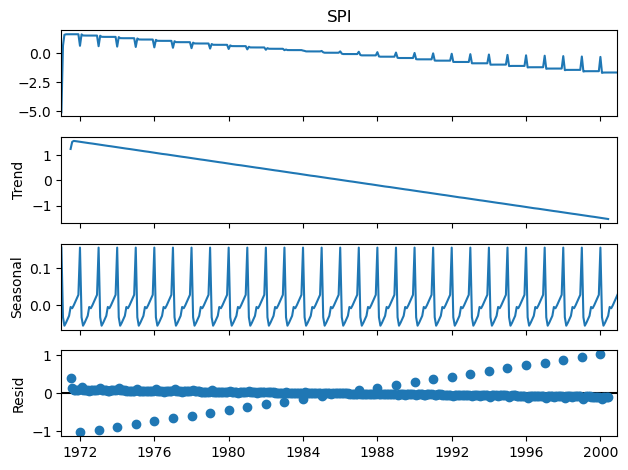

In [13]:
texas_forecasted_data  = pd.read_csv("spi_texas_forecasted.csv") 
texas_forecasted_data['Year'] = pd.to_datetime(texas_forecasted_data['Year'])
texas_forecasted_data.set_index('Year', inplace=True)
decomposition = seasonal_decompose(texas_forecasted_data['SPI'], model='additive').plot();



## SPAI Oklahoma Seosnal Decompose

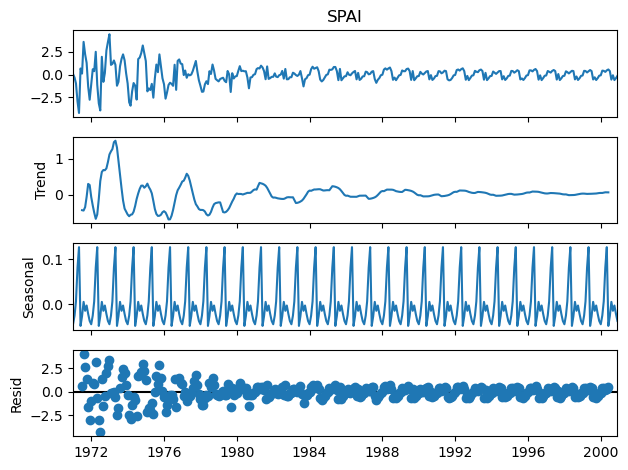

In [14]:
oklahoma_forecasted_data  = pd.read_csv("spai_oklahoma_forecasted.csv") 
oklahoma_forecasted_data['Year'] = pd.to_datetime(oklahoma_forecasted_data['Year'])
oklahoma_forecasted_data.set_index('Year', inplace=True)
decomposition = seasonal_decompose(oklahoma_forecasted_data['SPAI'], model='additive').plot();


## SPIA TEXAS Seosnal Decompose 

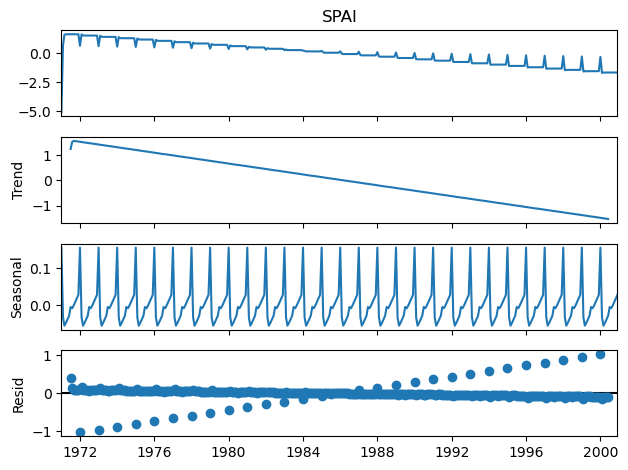

In [15]:
texas_forecasted_data  = pd.read_csv("spai_texas_forecasted.csv") 
texas_forecasted_data['Year'] = pd.to_datetime(texas_forecasted_data['Year'])
texas_forecasted_data.set_index('Year', inplace=True)
decomposition = seasonal_decompose(texas_forecasted_data['SPAI'], model='additive').plot();

